In [ ]:
!pip install prophet


In [ ]:
import os
import pandas as pd

try:
    df
except NameError:
    from google.colab import files
    uploaded = files.upload()   # upload State_time_series.csv
    df = pd.read_csv("State_time_series.csv")
    # if you need the 8222-row drop, uncomment the next line (you used this earlier)
    # df = df.iloc[8222:].reset_index(drop=True)

# Confirm Date column exists
if "Date" not in df.columns:
    raise KeyError("Column 'Date' not found. Check df.columns for the correct name.")

print("Original 'Date' dtype (unchanged):", df["Date"].dtype)

# Keep a backup of the original string representation
df["Date_str_backup"] = df["Date"].astype(str)

# Create a separate datetime column for internal operations (does NOT overwrite original)
df["Date_parsed"] = pd.to_datetime(df["Date_str_backup"], errors="coerce")

# Report parse problems if any
n_unparseable = df["Date_parsed"].isna().sum()
print("Parsed 'Date_parsed' dtype:", df["Date_parsed"].dtype)
print("Number of unparseable Date rows (Date_parsed is NaT):", n_unparseable)
if n_unparseable > 0:
    print("Examples of unparseable Date strings (up to 10):")
    print(df[df["Date_parsed"].isna()]["Date_str_backup"].head(10).tolist())

# Sanity check: show parsed date range (if any parsed)
if n_unparseable < len(df):
    print("Date_parsed range:", df["Date_parsed"].min(), "to", df["Date_parsed"].max())

# Show a few rows so you can visually confirm nothing overwritten
print(df[["Date", "Date_str_backup", "Date_parsed"]].head(8))

Saving State_time_series.csv to State_time_series.csv
Original 'Date' dtype (unchanged): object
Parsed 'Date_parsed' dtype: datetime64[ns]
Number of unparseable Date rows (Date_parsed is NaT): 0
Date_parsed range: 1996-04-30 00:00:00 to 2017-12-31 00:00:00
         Date Date_str_backup Date_parsed
0  1996-04-30      1996-04-30  1996-04-30
1  1996-04-30      1996-04-30  1996-04-30
2  1996-04-30      1996-04-30  1996-04-30
3  1996-04-30      1996-04-30  1996-04-30
4  1996-04-30      1996-04-30  1996-04-30
5  1996-04-30      1996-04-30  1996-04-30
6  1996-04-30      1996-04-30  1996-04-30
7  1996-04-30      1996-04-30  1996-04-30


In [ ]:
# Select only the needed columns (drop object 'Date')
df_multivariate = df[["RegionName", "ZHVI_AllHomes", "Date_parsed"]].copy()

# Sort by Region and Date_parsed (important for time-series operations)
df_multivariate = df_multivariate.sort_values(by=["RegionName", "Date_parsed"]).reset_index(drop=True)

# Rename Date_parsed -> Date for clarity
df_multivariate = df_multivariate.rename(columns={"Date_parsed": "Date"})

# Quick check
print(df_multivariate.head())
print(df_multivariate.info())


  RegionName  ZHVI_AllHomes       Date
0    Alabama        79500.0 1996-04-30
1    Alabama        79200.0 1996-05-31
2    Alabama        79500.0 1996-06-30
3    Alabama        79700.0 1996-07-31
4    Alabama        79700.0 1996-08-31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13212 entries, 0 to 13211
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   RegionName     13212 non-null  object        
 1   ZHVI_AllHomes  12438 non-null  float64       
 2   Date           13212 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 309.8+ KB
None


In [ ]:
# Handle missing values with backward fill within each RegionName group
df_multivariate["ZHVI_AllHomes"] = (
    df_multivariate.groupby("RegionName")["ZHVI_AllHomes"]
    .transform(lambda group: group.bfill())
)

# Drop any rows still NaN
df_multivariate = df_multivariate.dropna(subset=["ZHVI_AllHomes"]).reset_index(drop=True)

print("Final missing values:", df_multivariate["ZHVI_AllHomes"].isna().sum())
print("Final shape:", df_multivariate.shape)


Final missing values: 0
Final shape: (12856, 3)


In [ ]:
# Drop rows where ZHVI_AllHomes is still NaN
df_multivariate = df_multivariate.dropna(subset=["ZHVI_AllHomes"]).reset_index(drop=True)

print("Final missing values:", df_multivariate["ZHVI_AllHomes"].isna().sum())
print("Final shape:", df_multivariate.shape)
print("Remaining unique regions:", df_multivariate["RegionName"].nunique())


Final missing values: 0
Final shape: (12856, 3)
Remaining unique regions: 50


In [ ]:
# Step 4: Handle outliers in ZHVI_AllHomes
def handle_outliers(group, window=3, threshold=3.0):
    """
    Replace outliers with rolling median based on MAD (Median Absolute Deviation).
    """
    rolling_median = group.rolling(window=window, center=True, min_periods=1).median()
    diff = (group - rolling_median).abs()

    mad = diff.median()  # Median Absolute Deviation
    outlier_mask = diff > (threshold * mad)

    # Replace outliers with rolling median values
    group[outlier_mask] = rolling_median[outlier_mask]
    return group

# Apply outlier handling per Region
df_multivariate["ZHVI_AllHomes"] = (
    df_multivariate.groupby("RegionName")["ZHVI_AllHomes"]
    .transform(lambda g: handle_outliers(g))
)

print("Outlier handling done.")
print(df_multivariate.head())
print(df_multivariate.info())


Outlier handling done.
  RegionName  ZHVI_AllHomes       Date
0    Alabama        79350.0 1996-04-30
1    Alabama        79500.0 1996-05-31
2    Alabama        79500.0 1996-06-30
3    Alabama        79700.0 1996-07-31
4    Alabama        79700.0 1996-08-31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12856 entries, 0 to 12855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   RegionName     12856 non-null  object        
 1   ZHVI_AllHomes  12856 non-null  float64       
 2   Date           12856 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 301.4+ KB
None


Forecasting for one region




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/wsl3z2pz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/7fzanzwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60485', 'data', 'file=/tmp/tmp9v9ce7ms/wsl3z2pz.json', 'init=/tmp/tmp9v9ce7ms/7fzanzwb.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelsxh95lz4/prophet_model-20251003122421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/

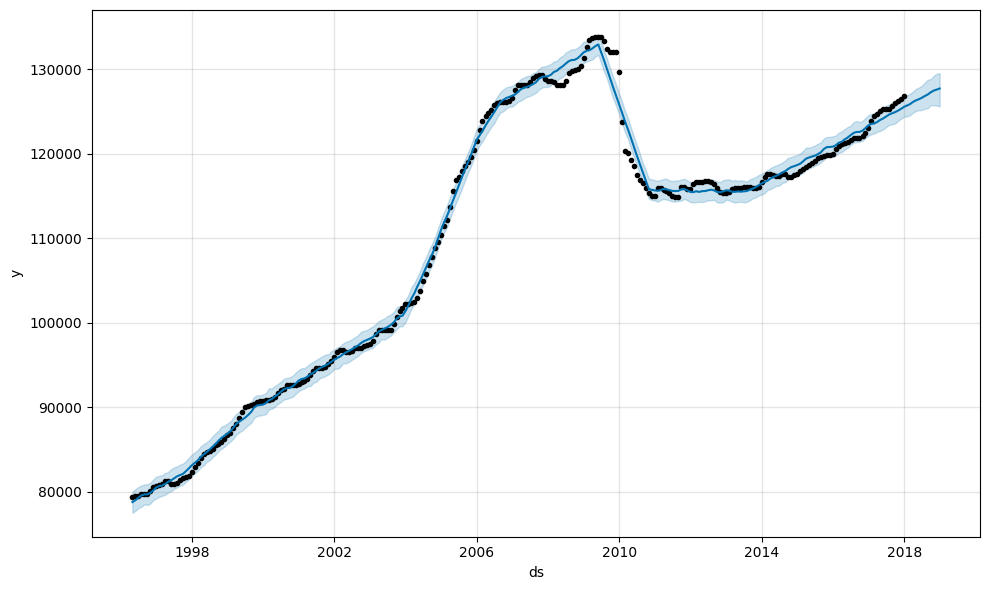

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Example: run for one region (say "Alabama")
region = "Alabama"

# Use the already preprocessed dataset
region_df = df_multivariate[df_multivariate["RegionName"] == region].copy()

# Prophet requires 'ds' for dates and 'y' for values
region_df = region_df.rename(columns={"Date": "ds", "ZHVI_AllHomes": "y"})

# Initialize and fit model
m = Prophet()
m.fit(region_df)

# Forecast next 12 months
future = m.make_future_dataframe(periods=12, freq="M")
forecast = m.predict(future)

# Plot forecast
fig = m.plot(forecast)
plt.show()


Loop through all 52 regions and train Prophet

In [ ]:
from prophet import Prophet
import joblib

# Get list of all unique regions
regions = df_multivariate["RegionName"].unique()

# Dictionary to hold Prophet models
models = {}

for region in regions:
    print(f"Training Prophet for: {region}")

    # Filter data for the region
    region_df = df_multivariate[df_multivariate["RegionName"] == region].copy()
    region_df = region_df.rename(columns={"Date": "ds", "ZHVI_AllHomes": "y"})

    # Initialize and fit Prophet
    m = Prophet()
    m.fit(region_df)

    # Save model for this region
    models[region] = m

# Save all models into one file
joblib.dump(models, "prophet_models.pkl")

print("All 52 region models trained and saved into prophet_models.pkl")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/xkqrzm7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/3vymtcpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94019', 'data', 'file=/tmp/tmp9v9ce7ms/xkqrzm7u.json', 'init=/tmp/tmp9v9ce7ms/3vymtcpn.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modeldzz0ztn7/prophet_model-20251003122430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Alabama


12:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/mbq5s59g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/onwalyfb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5637', 'data', 'file=/tmp/tmp9v9ce7ms/mbq5s59g.json', 'init=/tmp/tmp9v9ce7ms/onwalyfb.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelofbzc2zv/prophet_model-20251003122431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Alaska


12:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/rtqskj46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/974hhfb0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22379', 'data', 'file=/tmp/tmp9v9ce7ms/rtqskj46.json', 'init=/tmp/tmp9v9ce7ms/974hhfb0.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model4k4xu64_/prophet_model-20251003122431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Arizona


12:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/98r2nn56.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/5ijn816q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87079', 'data', 'file=/tmp/tmp9v9ce7ms/98r2nn56.json', 'init=/tmp/tmp9v9ce7ms/5ijn816q.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelev06i8r_/prophet_model-20251003122431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:31 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Arkansas
Training Prophet for: California


12:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/w3rgmq3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/sswlndcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31866', 'data', 'file=/tmp/tmp9v9ce7ms/w3rgmq3a.json', 'init=/tmp/tmp9v9ce7ms/sswlndcf.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model6_fw_plx/prophet_model-20251003122432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Colorado
Training Prophet for: Connecticut


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/ifqua89c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48841', 'data', 'file=/tmp/tmp9v9ce7ms/u91gpejk.json', 'init=/tmp/tmp9v9ce7ms/ifqua89c.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelpkjkr66x/prophet_model-20251003122432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/0rt0yo9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training Prophet for: Delaware
Training Prophet for: DistrictofColumbia


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26807', 'data', 'file=/tmp/tmp9v9ce7ms/gcif52fd.json', 'init=/tmp/tmp9v9ce7ms/w3s28sn1.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model3xt349g5/prophet_model-20251003122432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/mzu5kwvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/2h9c_nz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thr

Training Prophet for: Florida


12:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/j5jeqfbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/55nwrn1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38285', 'data', 'file=/tmp/tmp9v9ce7ms/j5jeqfbd.json', 'init=/tmp/tmp9v9ce7ms/55nwrn1x.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelalwrqhja/prophet_model-20251003122433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:33 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Georgia
Training Prophet for: Hawaii


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/ghz554pa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/xaw14k9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34690', 'data', 'file=/tmp/tmp9v9ce7ms/ghz554pa.json', 'init=/tmp/tmp9v9ce7ms/xaw14k9f.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model8x219o00/prophet_model-20251003122433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

Training Prophet for: Idaho
Training Prophet for: Illinois


12:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/qhxl0y9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/j5ocn9ga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39408', 'data', 'file=/tmp/tmp9v9ce7ms/qhxl0y9y.json', 'init=/tmp/tmp9v9ce7ms/j5ocn9ga.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model3pwu7x4a/prophet_model-20251003122433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Indiana


12:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/jsxw7kxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/doaeyszg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47320', 'data', 'file=/tmp/tmp9v9ce7ms/jsxw7kxz.json', 'init=/tmp/tmp9v9ce7ms/doaeyszg.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelwppyydxv/prophet_model-20251003122434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Iowa
Training Prophet for: Kansas


12:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/1f8x5ie9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/_pbz3q8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38813', 'data', 'file=/tmp/tmp9v9ce7ms/1f8x5ie9.json', 'init=/tmp/tmp9v9ce7ms/_pbz3q8l.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelplh858ic/prophet_model-20251003122434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Kentucky
Training Prophet for: Maine


12:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/ahvwmktk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/ua70yry_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78884', 'data', 'file=/tmp/tmp9v9ce7ms/ahvwmktk.json', 'init=/tmp/tmp9v9ce7ms/ua70yry_.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model448iyrnb/prophet_model-20251003122434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Maryland


12:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/40mj5ele.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/6hlds98u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95783', 'data', 'file=/tmp/tmp9v9ce7ms/40mj5ele.json', 'init=/tmp/tmp9v9ce7ms/6hlds98u.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modeloko1011r/prophet_model-20251003122435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:35 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Massachusetts
Training Prophet for: Michigan


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/8io23n6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/7s9a_bqt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87629', 'data', 'file=/tmp/tmp9v9ce7ms/8io23n6i.json', 'init=/tmp/tmp9v9ce7ms/7s9a_bqt.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelu85bipzz/prophet_model-20251003122435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

Training Prophet for: Minnesota
Training Prophet for: Mississippi


12:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/fp2a0n6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/i8zkk1nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39817', 'data', 'file=/tmp/tmp9v9ce7ms/fp2a0n6a.json', 'init=/tmp/tmp9v9ce7ms/i8zkk1nz.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelzqjergbk/prophet_model-20251003122435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Missouri


12:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/lvp47xo6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/uruzymxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15789', 'data', 'file=/tmp/tmp9v9ce7ms/lvp47xo6.json', 'init=/tmp/tmp9v9ce7ms/uruzymxb.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modeleba26qxr/prophet_model-20251003122436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:36 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Montana
Training Prophet for: Nebraska


12:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/k6r4twi4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/78pcwqs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94741', 'data', 'file=/tmp/tmp9v9ce7ms/k6r4twi4.json', 'init=/tmp/tmp9v9ce7ms/78pcwqs2.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelkavzqjbl/prophet_model-20251003122436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Nevada


12:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/lbwf1l8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/94wox8y4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39498', 'data', 'file=/tmp/tmp9v9ce7ms/lbwf1l8p.json', 'init=/tmp/tmp9v9ce7ms/94wox8y4.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelp1j3wbqa/prophet_model-20251003122436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:36 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: NewHampshire
Training Prophet for: NewJersey


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/uo8crm89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/xft7s45y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52280', 'data', 'file=/tmp/tmp9v9ce7ms/uo8crm89.json', 'init=/tmp/tmp9v9ce7ms/xft7s45y.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model92w414ep/prophet_model-20251003122436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training Prophet for: NewMexico
Training Prophet for: NewYork


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83253', 'data', 'file=/tmp/tmp9v9ce7ms/_tux_y0c.json', 'init=/tmp/tmp9v9ce7ms/qol8p62p.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model23_5hmic/prophet_model-20251003122437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/edopia1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/ttmmttmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/loc

Training Prophet for: NorthCarolina
Training Prophet for: NorthDakota


12:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/93y6jxdz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/ko4vnx0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22422', 'data', 'file=/tmp/tmp9v9ce7ms/93y6jxdz.json', 'init=/tmp/tmp9v9ce7ms/ko4vnx0j.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelogzu9y5t/prophet_model-20251003122437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:37 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Ohio
Training Prophet for: Oklahoma


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/dypp1l_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78186', 'data', 'file=/tmp/tmp9v9ce7ms/ye_dnp8j.json', 'init=/tmp/tmp9v9ce7ms/dypp1l_g.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelkk547mw1/prophet_model-20251003122437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/6z5btz2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training Prophet for: Oregon
Training Prophet for: Pennsylvania


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/kgi__9ko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/mtl10o89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55255', 'data', 'file=/tmp/tmp9v9ce7ms/kgi__9ko.json', 'init=/tmp/tmp9v9ce7ms/mtl10o89.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modeladhdhdlg/prophet_model-20251003122438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training Prophet for: RhodeIsland


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/rx33ykig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/1imuju8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51200', 'data', 'file=/tmp/tmp9v9ce7ms/rx33ykig.json', 'init=/tmp/tmp9v9ce7ms/1imuju8a.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelrs91yf06/prophet_model-20251003122438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing

Training Prophet for: SouthCarolina
Training Prophet for: SouthDakota


12:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/t8lw31wc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/9abstvlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93438', 'data', 'file=/tmp/tmp9v9ce7ms/t8lw31wc.json', 'init=/tmp/tmp9v9ce7ms/9abstvlr.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model23irbb57/prophet_model-20251003122438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:38 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Tennessee
Training Prophet for: Texas


12:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/_mfj_ovn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/jg_r8m8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87905', 'data', 'file=/tmp/tmp9v9ce7ms/_mfj_ovn.json', 'init=/tmp/tmp9v9ce7ms/jg_r8m8m.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model7vi4i4yc/prophet_model-20251003122439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet for: Utah


12:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/wux0hqps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/pj5wc7x1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75670', 'data', 'file=/tmp/tmp9v9ce7ms/wux0hqps.json', 'init=/tmp/tmp9v9ce7ms/pj5wc7x1.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelkxfm2tco/prophet_model-20251003122439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:39 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Vermont
Training Prophet for: Virginia


12:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/khwbpa0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/9iahkuli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41466', 'data', 'file=/tmp/tmp9v9ce7ms/khwbpa0n.json', 'init=/tmp/tmp9v9ce7ms/9iahkuli.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_modelc36_3nzi/prophet_model-20251003122439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:39 - cmdstanpy - INFO - Chain [1] 

Training Prophet for: Washington
Training Prophet for: WestVirginia


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/fm5e3jlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/gqcwb1on.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32284', 'data', 'file=/tmp/tmp9v9ce7ms/fm5e3jlr.json', 'init=/tmp/tmp9v9ce7ms/gqcwb1on.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model7fz1_se8/prophet_model-20251003122439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training Prophet for: Wisconsin
Training Prophet for: Wyoming


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/9vjxe6or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v9ce7ms/z0m5yp8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70024', 'data', 'file=/tmp/tmp9v9ce7ms/9vjxe6or.json', 'init=/tmp/tmp9v9ce7ms/z0m5yp8x.json', 'output', 'file=/tmp/tmp9v9ce7ms/prophet_model241ojdzy/prophet_model-20251003122440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


All 52 region models trained and saved into prophet_models.pkl


save them

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


            ds           yhat     yhat_lower     yhat_upper
268 2018-08-31  540365.335795  531705.880287  548876.646348
269 2018-09-30  543154.514242  531966.943959  553190.438077
270 2018-10-31  545910.493494  533543.204804  556933.151318
271 2018-11-30  548653.569992  532775.876670  563165.667313
272 2018-12-31  550956.752203  533763.458205  566442.998064


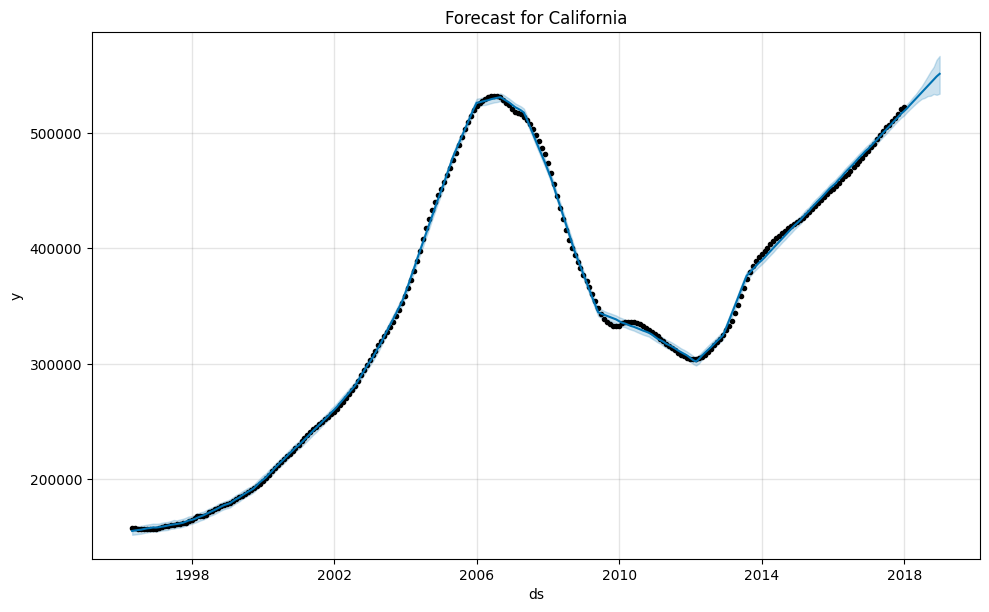

In [ ]:
import joblib
import matplotlib.pyplot as plt

# Load all trained models
models = joblib.load("prophet_models.pkl")

# Example: Forecast for one region (say California)
region = "California"
model = models[region]

# Create future dataframe (next 12 months)
future = model.make_future_dataframe(periods=12, freq="M")
forecast = model.predict(future)

# Show forecast
print(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail())

# Plot forecast
fig = model.plot(forecast)
plt.title(f"Forecast for {region}")
plt.show()
